# ウェザーニュースチュートリアル

In [ ]:
# 参考サイト
# https://signate.jp/competitions/169/tutorials/124
# https://pypi.org/project/signate/
# https://qiita.com/insilicomab/items/d757339d97b44feaff01
# https://community.insaid.co/hc/en-us/community/posts/360048243414-Installing-Importing-of-Basemap-in-Google-Colab

## Colabの準備とデータセットのダウンロード

In [ ]:
# opencvのインストール
!pip install opencv-python
# basemapのインストール
!apt-get install -q libgeos-3.5.0
!apt-get install -q libgeos-dev
!pip install -q https://github.com/matplotlib/basemap/archive/master.zip
!pip install -q pyproj==1.9.6
# signate CLIのインストール
!pip install signate

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth


auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


Download 100%.


In [ ]:
# SIGNATEで開催されているコンピ一覧の表示
! signate list

In [ ]:
# コンペのデータセットをダウンロード
! signate files --competition-id=270

In [ ]:
# データセットのダウンロード　fileIDを指定すれば個別にダウンロード可能
! signate download --competition-id=270

In [ ]:
# 解凍→このファイルと同じ階層にtrainフォルダを置く（マウント済みの前提）
# ! unzip sat_image_2017_01.zip
# ! unzip sat_image_2017_02.zip

## チュートリアル内容の確認

### 衛星画像
本コンペティションで使用する衛星画像の種類は赤外画像です。地表面・雲・大気から放射される赤外線を観測し、温度を測定しています。可視画像は昼間しか観測できないのに対し、赤外画像は24時間観測できるので、一定間隔で連続した画像を得ることができます。

元々のデータは温度（輝度温度）のデータですが、配布したデータは低い温度ほど白くなるよう調整した256階調グレースケールの画像ファイルです。

In [ ]:
path = "/content/drive/MyDrive/Dev/SIGNATE/"

In [ ]:
import numpy as np
import cv2
import os
# 圧縮・読み込み・書き出しなど
import gzip
# ディレクトリとファイルの操作
import shutil
from datetime import datetime as dt
from datetime import timedelta
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# 警告の制御
import warnings
warnings.filterwarnings('ignore', category=matplotlib.MatplotlibDeprecationWarning)

####夏と冬の違い
では実際の衛星画像を見てみましょう。衛星画像自体は見たことがあっても、夏と冬の画像を並べて見ることはなかなかありません。そこで（左）2017年8月1日00UTCと、（右）2017年12月27日00UTCの画像を並べて見てみましょう。

image shape :  (672, 512)
data type :  uint8


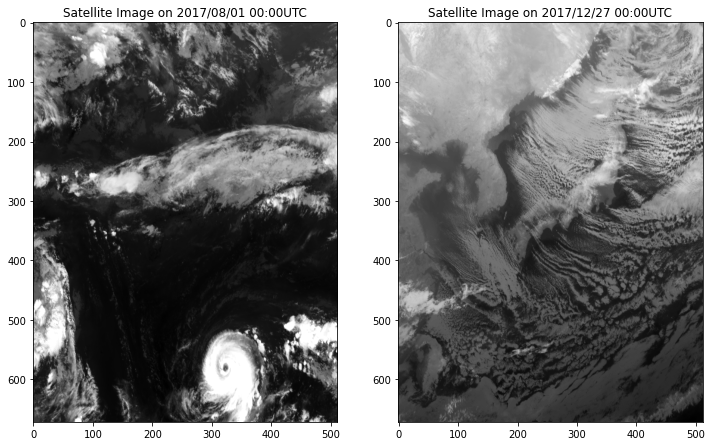

In [ ]:
file1 = path + "data/2017-08-01-00-00.fv.png"
file2 = path + "data/2017-12-27-00-00.fv.png"

# 画像の読み込み
img1 = cv2.imread(file1, 0)
img2 = cv2.imread(file2, 0)

print( "image shape : ", img1.shape )
print( "data type : ", img1.dtype )

fig, axes = plt.subplots(1, 2, figsize=(12,8))
# ウインドウ上に表示
axes[0].imshow(img1, cmap='gray')
axes[0].set_title("Satellite Image on 2017/08/01 00:00UTC")
axes[1].imshow(img2, cmap='gray')
axes[1].set_title("Satellite Image on 2017/12/27 00:00UTC")
plt.show()

余談ですが、画像ファイルのshapeは(672, 512)、データ型はuint8となっています。

さて見比べてみますと、随分と印象が異なることがわかります。夏は陸地・海面ともに温度が高くなっているため黒く写り、また雲頂が10000mを超える積乱雲群は雲頂温度が低くて真っ白に写ります。このため黒白のコントラストがはっきりします。なお南海上の渦巻く白い雲域は台風5号です。

これに対し冬は陸地が冷えるためグレーになり、海陸の温度差が広がって海岸線がはっきり見えるようになります。また雲も夏のような雲頂の高い雲が少なくなり、ほとんどがグレーで写っています。このため全般にグレー寄りの色となります。

この様子をヒストグラムでも見てみましょう。2017年8月と2017年12月の、それぞれ1ヶ月分の衛星画像を読み込みます。

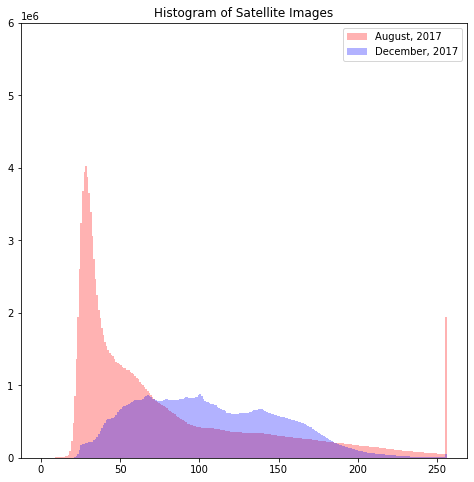

In [ ]:
img08 = []
img12 = []
date08 = dt(2017, 8 , 1, 0, 0, 0)
date12 = dt(2017, 12 , 1, 0, 0, 0)

# 1ヶ月分の衛星画像を読み込む
for i in range(31*24):
    file08 = path + "train2/sat/{year}-{month:02}-{day:02}/{year}-{month:02}-{day:02}-{hour:02}-00.fv.png".\
                    format(year=date08.year, month=date08.month, day=date08.day, hour=date08.hour)
    if os.path.exists(file08):
        img = cv2.imread(file08, 0)
        img08.append(img)
        
    file12 = path + "train2/sat/{year}-{month:02}-{day:02}/{year}-{month:02}-{day:02}-{hour:02}-00.fv.png".\
                    format(year=date12.year, month=date12.month, day=date12.day, hour=date12.hour)
    if os.path.exists(file12):
        img = cv2.imread(file12, 0)
        img12.append(img)

    date08 = date08 + timedelta(hours=1)
    date12 = date12 + timedelta(hours=1)

# ヒストグラム作成
all_img08 = np.concatenate(img08).flatten()
all_img12 = np.concatenate(img12).flatten()

fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.hist(all_img08, bins=np.arange(256 + 1), alpha=0.3, color="r", label="August, 2017")
ax.hist(all_img12, bins=np.arange(256 + 1), alpha=0.3, color="b", label="December, 2017")
ax.set_title("Histogram of Satellite Images")
ax.set_ylim(0, 6000000)
plt.legend()
plt.show()

8月は雲のないエリアがほぼ黒になるため画素値の小さいところにピークがありますが、冬は陸地もグレーになるので真ん中あたりに集まっています。

また画素値が200以上になると夏の方が多くなっています。255にピークがあるのは、一定閾値以下の温度をまとめて255にしているためです。

####天気パターンによる違い
では次に天気パターンによる違いの一例をご紹介します。（左）2017年4月11日00UTCは前線を伴った低気圧が日本列島に接近したときの衛星画像、（右）2017年6月29日18UTCは長崎・壱岐市で記録的な大雨となったときの衛星画像です。

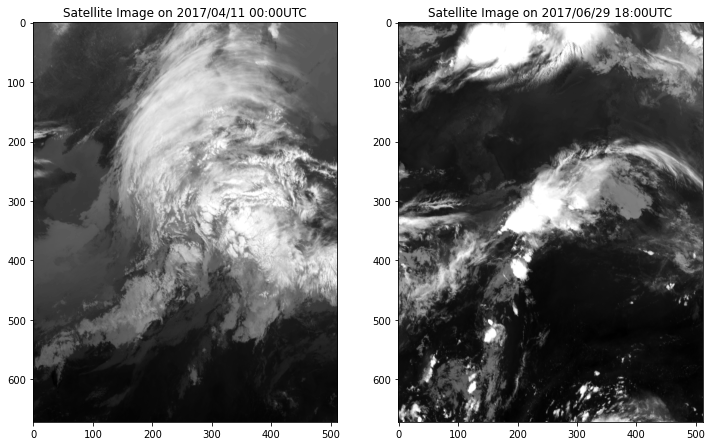

In [ ]:
file3 = path + "data/2017-04-11-00-00.fv.png"
file4 = path + "data/2017-06-29-18-00.fv.png"

img3 = cv2.imread(file3, 0)
img4 = cv2.imread(file4, 0)

fig, axes = plt.subplots(1, 2, figsize=(12,8))
axes[0].imshow(img3, cmap='gray')
axes[0].set_title("Satellite Image on 2017/04/11 00:00UTC")
axes[1].imshow(img4, cmap='gray')
axes[1].set_title("Satellite Image on 2017/06/29 18:00UTC")
plt.show()

左側、画像の中央付近から南東・南西に伸びる帯状の雲域は前線に伴うものです。また画像の上部に半円状に広がる雲は上空の強い風によって広がったもので、はけで掃いたような形状をしています。この低気圧による雲域は、層状の雲やもくもくとした積雲が混ざっており、高さも様々なため斑ら模様のようになっています。一般に低気圧に伴う雲域は、低気圧の移動とともに順調に西から東へ流れていきます。

一方で右側、画像中央付近の白い雲は積乱雲の塊で、雲頂高度が高いため真っ白になっています。また積乱雲群は雲域の輪郭が比較的シャープになることも特徴の1つです。こうした雲も上空の風によって東寄りに流されますが、発生源は地上近くにあって動きが遅いため、結果として積乱雲が同じ場所に長時間掛かり続けることになり、記録的な大雨をもたらすことがあります。

なお各日の天気図については気象庁ウェブサイトをご参照下さい。

気象庁：2017年4月（https://www.data.jma.go.jp/fcd/yoho/data/hibiten/2017/201704.pdf）

気象庁：2017年6月（https://www.data.jma.go.jp/fcd/yoho/data/hibiten/2017/201706.pdf）


#### 日変化がわかる場合
では次に、朝と昼の見え方の違いを紹介します。（左）2017年12月26日21UTC、つまり日本時間で27日の朝の衛星画像です。（右）2017年12月27日03UTC、つまり同じ日の正午の衛星画像です。

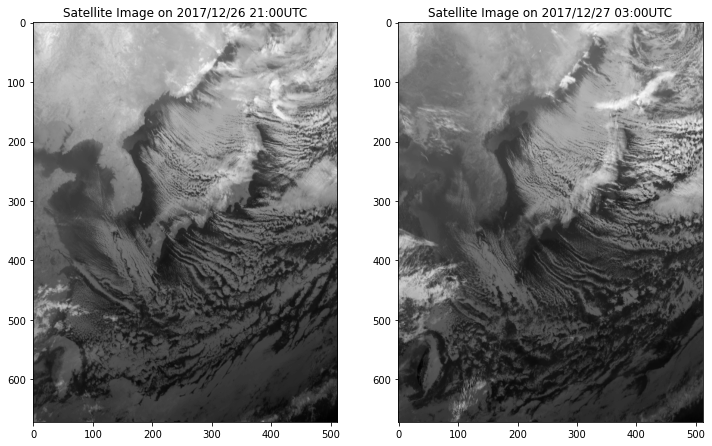

In [ ]:
file5 = path + "data/2017-12-26-21-00.fv.png"
file6 = path + "data/2017-12-27-03-00.fv.png"

img5 = cv2.imread(file5, 0)
img6 = cv2.imread(file6, 0)

fig, axes = plt.subplots(1, 2, figsize=(12,8))
axes[0].imshow(img5, cmap='gray')
axes[0].set_title("Satellite Image on 2017/12/26 21:00UTC")
axes[1].imshow(img6, cmap='gray')
axes[1].set_title("Satellite Image on 2017/12/27 03:00UTC")
plt.show()

もうお気づきかもしれませんが、1日で最も気温が下がる朝は陸地が冷えてグレーになり、海岸線もはっきりわかります（左）。これに対し、正午になると陸地の気温は上がってやや黒よりのグレーに変化し、朝に比べると海岸線がわかりにくくなっています。

（一般に日射の有無によって温度が大きく変化する陸地に比べ、海は比較的温度の日変化が小さい特徴があります。）

####データの欠損について
衛星画像の紹介はここまでと致しますが、画像の欠損について補足説明をします。データの説明にも記載していますが、画像ファイルそのものが欠損している場合があり注意が必要です。また以下の例のように、画像ファイルはあっても中身が一部欠損している場合もあるのでご確認下さい。このケースでは画像の上部が欠損した状態になっています。

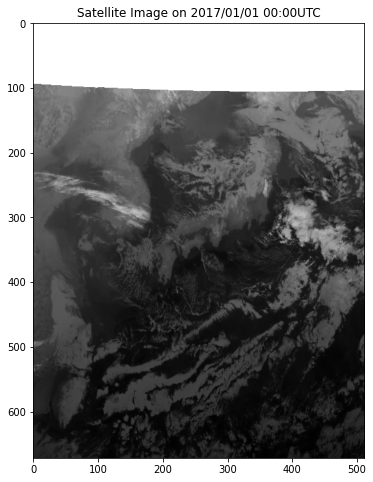

In [ ]:
file7 = path + "data/2017-01-01-00-00.fv.png"
img7 = cv2.imread(file7, 0)

fig, ax = plt.subplots(1, 1, figsize=(6,8))
ax.imshow(img7, cmap='gray')
ax.set_title("Satellite Image on 2017/01/01 00:00UTC")
plt.show()

###気象データ
本コンペティションで使用する気象データは、コンピュータによる数値シミュレーションで解析した大気の3次元データです。ファイルは気象要素・高度ごとに分かれており、1ファイルは水平面の2次元データとなっています。バイナリデータですが、gzip圧縮して配布しています。

####関数の準備
まず最初にいくつか関数を定義しておきます。まずはgzipされたファイルを解凍し、バイナリデータの読み込みを行う関数です。あらかじめ全てのファイルを解凍しておいても良いかと思いますが、容量も大きくなりますので、ここでは読み込むファイルのみ解凍して読み込むようにしています。バイナリデータの読み込みにはNumpyを使用します。

In [ ]:
def Read_gz_Binary(file):
    file_tmp = file + "_tmp"
    with gzip.open(file, 'rb') as f_in:
        with open(file_tmp, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    
    bin_data = np.fromfile(file_tmp, np.float32)
    os.remove(file_tmp)
    return bin_data.reshape( [168,128] )

次に欠損値の穴埋め処理をします。

気象データは衛星データと同じ緯度経度の範囲で用意していますが、元データがそれより狭い範囲しかないため、欠損箇所があります。具体的には2〜153行目、及び8列目以降について値が存在し、それ以外は欠損値として0が代入されています。

本チュートリアルでは、簡易な方法として値が存在する範囲の縁辺の値をそのまま外側へコピーする形で補完をして、可視化することにします。

In [ ]:
def fill_lack_data(data):
    # まず欠損行の穴埋めは、値が存在する上下端の行の値をそのままコピーする
    data[0:2] = data[2]
    data[154:] = data[153]

    # 欠損列の穴埋めも、値が存在する左右端の列の値をそのままコピーする
    data[:, :8] = data[:, 8].reshape(-1,1)
    return data

次は天気図描画をする関数です。描画にはBasemapを使用しますが、ここではBasemapについての細かい説明は割愛します。

描画の種類として、以下の3つのパターンを用意しています。

等値線を引くだけのcontour
値によって色を塗り分けるshaded
風の矢羽と等高線を描くbarb

In [ ]:
def draw_weather_map(data=None, u=None, v=None, draw="shaded", levels=None):    
    # 緯度経度で範囲を指定する
    north = 48.
    south = 20.
    east = 150.
    west = 118.
    grid_size = [168,128]

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1,1,1)

    # 地図の表示
    m = Basemap(llcrnrlat=south, urcrnrlat=north, llcrnrlon=west, urcrnrlon=east, projection='cyl', resolution='l')

    # 海岸線を引く
    m.drawcoastlines()

    parallels = np.arange(20,50,10)
    m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
    meridians = np.arange(110,160,10)
    m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

    lons, lats = m.makegrid(grid_size[1], grid_size[0])
    x, y = m(lons, lats)

    if draw == "shaded":
        cs = m.contourf(x, y, data[::-1, :], levels=levels)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="2%", pad=0.1)
        plt.colorbar(cs, cax=cax)
    elif draw == "contour":
        cs = m.contour(x, y, data[::-1, :], levels=levels, linewidths=3)
        cs.clabel(fmt='%d', fontsize=16)
    elif draw == "barb":
        cs = m.contour(x, y, data[::-1, :], levels=levels, linewidths=3)
        cs.clabel(fmt='%d', fontsize=16)
        cs = m.barbs(x[::8,::8], y[::8,::8], u[::-1, :][::8,::8], v[::-1, :][::8,::8])
    
    plt.show()

それでは可視化をしていきましょう。以下全て2017年4月11日00UTCのデータを使います。実は衛星画像のコーナーでも同じ日時を使っていて、低気圧が接近したケースとして取り上げていました。合わせて見ていただければ、より理解の助けとなると思います。

####850hPaの気温
まずは欠損範囲の確認をしてみます。ここでは850hPaの気温を描画してみます。データの説明にも記載しましたが、気象では高さ方向を気圧で表す場合があります。850hPaの高度は（一定値ではありませんが）おおよそ1500mです。

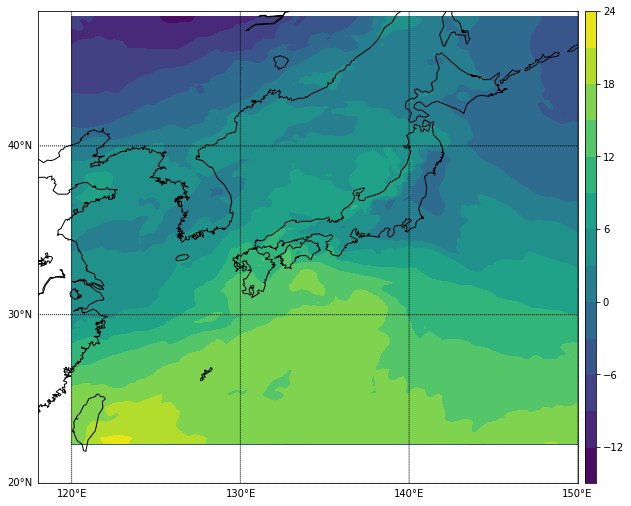

In [ ]:
file14 = path + "data/TMP.850.3.2017041100.gz"
data14 = Read_gz_Binary( file14 )
draw_weather_map(data14-273.15, draw="shaded", levels=list(np.arange(-15, 25, 3)))

画像の北側に少しと、南側に欠損箇所があります。また西側にも欠損箇所があります。

ではこの欠損箇所を簡易な方法で埋めてしまいます。

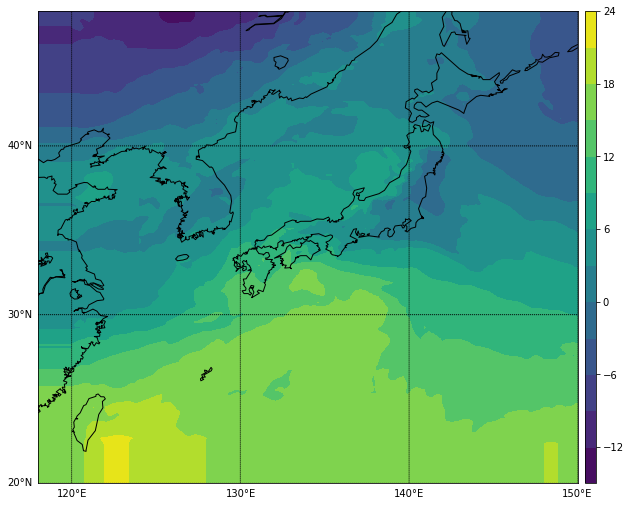

In [ ]:
file14 = path + "data/TMP.850.3.2017041100.gz"
data14 = Read_gz_Binary( file14 )
data14 = fill_lack_data( data14 )
draw_weather_map(data14-273.15, draw="shaded", levels=list(np.arange(-15, 25, 3)))

####海面気圧
では次に天気図でお馴染みの気圧を可視化してみます。等圧線は4hPaごとに引かれています。


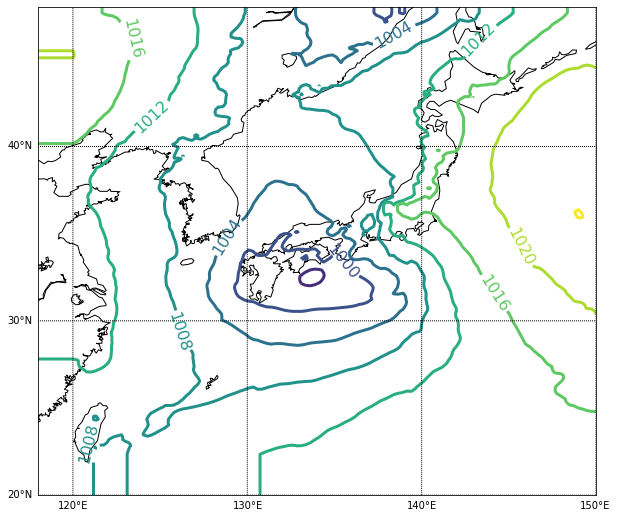

In [ ]:
file8 = path + "data/PRMSL.msl.3.2017041100.gz"
data8 = Read_gz_Binary( file8 )
data8 = fill_lack_data( data8 )
draw_weather_map(data8/100, draw="contour", levels=list(np.arange(992, 1028, 4)))

####700hPaの湿度
次に高度およそ3000mあたり、富士山頂より少し低いところ、700hPaの湿度を見てみます。この高度の湿度は、ものすごく大雑把に言って、雲の広がりを簡単に把握するために利用されています。

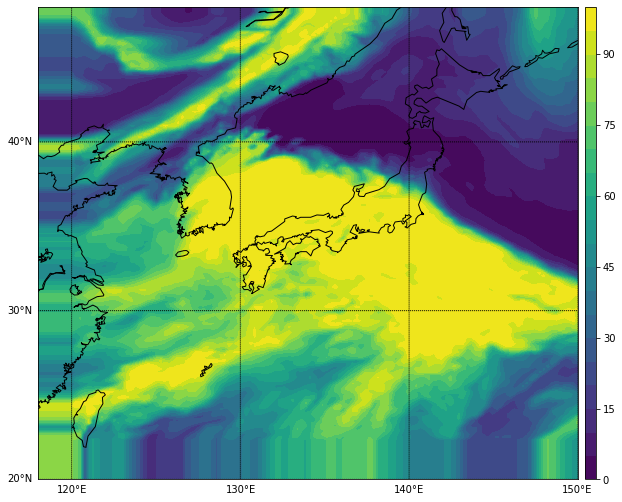

In [ ]:
file9 = path + "data/RH.700.3.2017041100.gz"
data9 = Read_gz_Binary( file9 )
data9 = fill_lack_data( data9 )
draw_weather_map(data9, draw="shaded", levels=list(np.arange(0, 101, 5)))

大雑把に言って、黄色いところが雲域と見て差し支えありません。ここで低気圧の南西側、沖縄付近に伸びる黄色の帯状のところが寒冷前線、低気圧の東側に幅広く広がる黄色いところが温暖前線に伴う雲域と考えることができます。

さて実際の衛星画像ではもっと北側まで雲が広がっていることがわかるかと思います。この雲は、下でも取り上げますが、もっと高い高度の雲と考えられます。

####500hPaの高度
次は500hPa、だいたい5500mくらいの高さを等高線で描画してみます。地図を見るときのように、高度が低いところが低気圧、高度が高いところが高気圧と見ることができます。

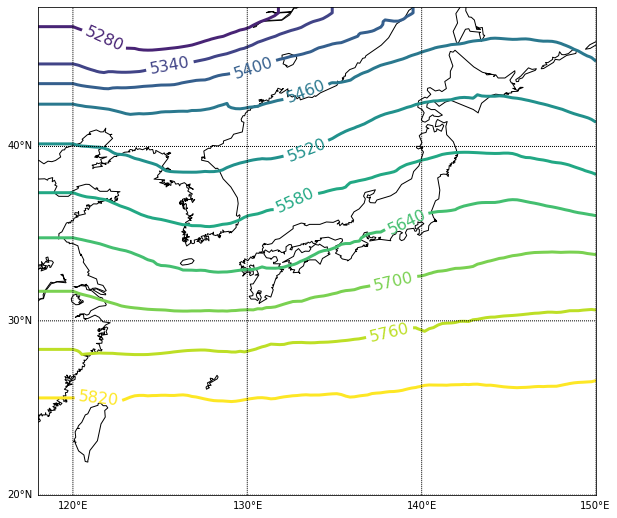

In [ ]:
file10 = path + "data/HGT.500.3.2017041100.gz"
data10 = Read_gz_Binary( file10 )
data10 = fill_lack_data( data10 )
draw_weather_map(data10, draw="contour", levels=list(np.arange(5220, 5880, 60)))

閉じた円の等高線がないためわかりにくいかもしれませんが、北緯30〜40度あたりを見ると朝鮮半島から九州あたり、南に凸の形をした等高線になっています。同じ緯度で比べるとこの部分は周辺よりも高度が低くなっているので、低気圧となっています（気象用語でトラフと呼びます）。逆に日本の東海上から北海道あたりは北に凸の形状となっていて、高気圧になっています（気象用語でリッジと呼びます）。一般に地上の低気圧・高気圧に比べて、上空のトラフ・リッジは少し西側にずれたところに位置しており、またこのような状態の時に低気圧は発達します。

さて次に風の流れを見てみますが、一般に上空に行くほど風はほぼ等高線に平行に吹いており、上の500hPaでも等高線に沿って大気は流れています。この様子をさらに上空の、飛行機が飛ぶ高度の風で紹介します。

####300hPaの風
それでは高度およそ9200mほど、300hPaの風を描画します。

気象データでは、風の値は風向・風速で表す場合と、東西成分・南北成分で表す場合があり、本コンペティションで用いるようなコンピュータ解析にもとづくデータは東西成分・南北成分で表されることが多いです。東西成分・南北成分をそれぞれ描画してもわかりにくいと思いますので、ここでは2つを用いて矢羽表記で描画してみます。

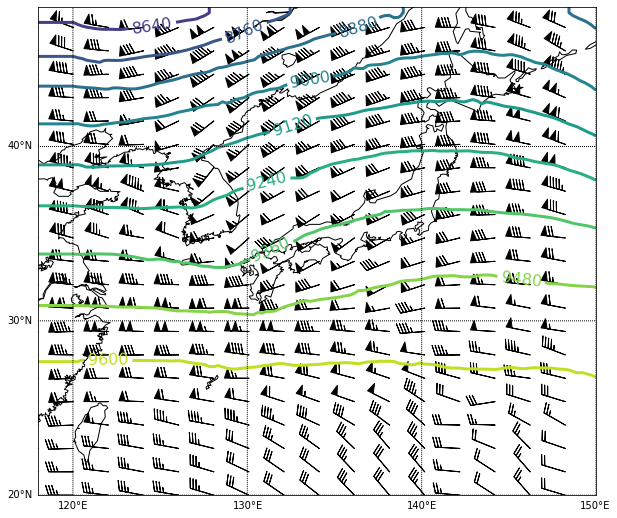

In [ ]:
file11 = path + "data/UGRD.300.3.2017041100.gz"
file12 = path + "data/VGRD.300.3.2017041100.gz"
file13 = path + "data/HGT.300.3.2017041100.gz"

data11 = Read_gz_Binary( file11 )
data11 = fill_lack_data( data11 )
data12 = Read_gz_Binary( file12 )
data12 = fill_lack_data( data12 )
data13 = Read_gz_Binary( file13 )
data13 = fill_lack_data( data13 )
draw_weather_map(data13, u=data11/0.5144, v=data12/0.5144, draw="barb", levels=list(np.arange(8400,9840,120)))

矢羽はノット単位(kt)で表されており、大きなペナントが50kt、長い横棒が10kt、短い横棒が5ktです。50ktはだいたい時速92.6kmほどなので、高速道路を走る自動車くらいの速度です。また等高線を一緒に描画しています。

いかがでしょうか？強いところでは110ktまで現れており、高速道路を走る自動車よりもかなり速い速度で風が吹いていることがわかります。また上で述べたとおり、概ね等高線に平行に風が吹いていることもわかります。

さらに衛星画像と合わせてみると、日本海〜極東ロシア上空の南西風によって、あの半円状に広がる雲域が形作られ、流されている様子がイメージできるかと思います。

####風向・風速の計算
さて、最後に風の東西成分・南北成分から、風向・風速を計算する方法をご紹介します。

In [ ]:
# 風の東西成分・南北成分から、風向風速を計算する
def Calc_Wind(u,v):
    wspd = np.sqrt( u**2 + v**2 )
    wdir = np.rad2deg( np.arctan2(u,v) )+180
    return np.round(wspd,1), np.round(wdir,0)

In [ ]:
Calc_Wind(u=2, v=-3)

(3.6, 326.0)